# Goal Babbling with direct optimization 


In our previous implementations of goal babbling, when a goal is chosen, the robotic agent performs only one movement in order to reach this goal. This movement, however could be found through optimization of a fast surrogate forward model (or simulations of movements in the head of the robot), e.g. with the Covariance Matrix Adaptation Evolutionary Strategy (CMAES) optimization method, and the Locally Weighted Linear Regression (LWLR) surrogate forward model (the combination of which we call "CMAES-LWLR").

We've shown how to define and use sensorimotor models in [this notebook](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/learning_sensorimotor_models.ipynb), and summarized the different available sensorimotor models [here](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/summary_available_models.ipynb).

In this tutorial, however, we explain how an agent can explore a sensorimotor environment with multiple exploration steps for one particular goal. A surrogate inverse model is used to find a good motor command to reach the new goal and serves to bootstrap an optimization method that directly executes motor commands and receives feedback from the environment, with a budget of robot experiments for each new goal.

We will use CMAES as the direct optimization method to reach the current goal, and the nearest neighbor (NN) algorithm as a fast surrogate inverse model. We test this idea on a simple 2D simulated 7-DOF robotic arm.

Let's first define the robotic environment:

In [1]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')
environment.noise = 0.01

print "Motor bounds", environment.conf.m_bounds
print "Sensory bounds", environment.conf.s_bounds

Motor bounds [[-1.04719755 -1.04719755 -1.04719755 -1.04719755 -1.04719755 -1.04719755
  -1.04719755]
 [ 1.04719755  1.04719755  1.04719755  1.04719755  1.04719755  1.04719755
   1.04719755]]
Sensory bounds [[-0.5 -1. ]
 [ 1.   1. ]]


The arm has 7 joints and has total lenght 1. The motor bounds here do not allow joints to rotate all around but only in the range [-60°, 60°], or [-1.05, 1.05rad]. The position of the end-effector will be the variables to optimize, they fairly cover the intervals X in [-0.5, 1] and Y in [-1, 1].

Now, we define the surrogate model using exact nearest neighbor lookup:

In [2]:
from explauto import SensorimotorModel
model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')
model.mode = "exploit" # We don't want the sensorimotor model to add exploration noise

Let's have a look at what could be random motor configurations, and at the same time we bootstrap the surrogate model with 100 points:

Populating the interactive namespace from numpy and matplotlib


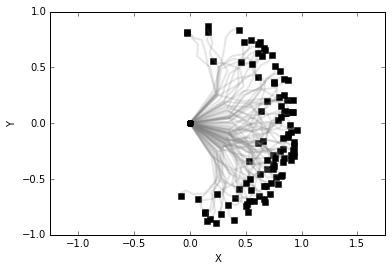

In [3]:
%pylab inline
ax = axes()
plt.axis('equal')

for m in environment.random_motors(n=100):
    s = environment.compute_sensori_effect(m)
    environment.plot_arm(ax, m, alpha=0.2)
    model.update(m, s)

We can see that most random motor commands explore the border of the reachable space on the bottom, right and top regions.

Now we define the interest model, that will choose goals. We use random goals in this tutorial but any interest model can be used instead:

In [4]:
from explauto.interest_model.random import RandomInterest
im_model = RandomInterest(environment.conf, environment.conf.s_dims)

We have all the building blocks to do goal babbling with direct optimization:

Populating the interactive namespace from numpy and matplotlib
Goal: [ 0.98306831 -0.91316634] Reaching Error: 0.350214930417


/home/sforesti/scm/Flowers/explauto/explauto/sensorimotor_model/inverse/cma.py:2935: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x0 == str(x0):
/home/sforesti/scm/Flowers/explauto/explauto/sensorimotor_model/inverse/cma.py:957: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if bounds in (None, [None, None]):


Goal: [ 0.85385666 -0.55595218] Reaching Error: 0.041284684256
Goal: [ 0.77123642 -0.95041672] Reaching Error: 0.235291942514
Goal: [ 0.02901553 -0.69701056] Reaching Error: 0.0222818891107
Goal: [-0.26092483 -0.16146275] Reaching Error: 0.123184765352
Goal: [ 0.84957416 -0.68505884] Reaching Error: 0.105479225222
Goal: [ 0.12389227 -0.98191389] Reaching Error: 0.0557754106613
Goal: [-0.31310967  0.91813455] Reaching Error: 0.195199796338
Goal: [-0.32827075  0.0282725 ] Reaching Error: 0.321220368892
Goal: [-0.22685243 -0.27254349] Reaching Error: 0.0443400999089
Goal: [ 0.22257244  0.35157956] Reaching Error: 0.0137468272298
Goal: [ 0.45175877  0.83124003] Reaching Error: 0.0286030173537
Goal: [ 0.45899309 -0.87458435] Reaching Error: 0.0143368771813
Goal: [ 0.39699576 -0.4670715 ] Reaching Error: 0.0379835952872
Goal: [-0.05972663 -0.40972681] Reaching Error: 0.0407947136892
Goal: [ 0.04140544 -0.67562285] Reaching Error: 0.00894428966815
Goal: [-0.20312066 -0.87156812] Reaching Erro

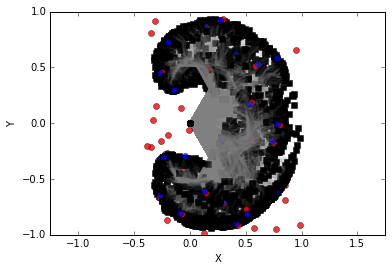

In [5]:
import numpy as np
from explauto.sensorimotor_model.inverse.cma import fmin as cma_fmin

%pylab inline
ax = axes()
plt.axis('equal')


n_goals = 50 # Number of goals
cma_maxfevals = 50 # Maximum error function evaluations by CMAES (actually CMAES will slightly overshoot it)
cma_sigma0 = 0.2 # Standard deviation in initial covariance matrix


for i in range(n_goals):
    s_g = im_model.sample() # Sample a random goal
    m0 = model.inverse_prediction(s_g) # Find the nearest neighbor of s_g and output the corresponding m
    
    def error_f(m_): # Error function corresponding to the new goal s_g.
        environment.plot_arm(ax, m_, alpha=0.1)
        s_ = environment.compute_sensori_effect(m_) # Execute a motor command 
        model.update(m_, s_) # Update the surrogate model
        return np.linalg.norm(s_ - s_g) # Output the distance between the reached point s_ and the goal s_g
    
    # Call CMAES with the error function for the new goal and use m0 to bootstrap exploration
    m = cma_fmin(error_f, m0, cma_sigma0, options={'bounds':[environment.conf.m_mins, environment.conf.m_maxs],
                                                   'verb_log':0, # don't flood my output...
                                                   'verb_disp':False, # ...seriously
                                                   'maxfevals':cma_maxfevals})[0]
    
    s = environment.compute_sensori_effect(m) # Execute best motor command found by CMAES (optional)
    model.update(m, s) # Update the surrogate model
    
    plt.plot(s_g[0], s_g[1], "or", alpha=0.8) # Plot goal in red
    plt.plot(s[0], s[1], "ob", alpha=0.8) # Plot reached point in blue
    print "Goal:", s_g, "Reaching Error:", np.linalg.norm(s_g - s)

The red points are the goals, and the blue points are the corresponding best reached point.
For each of the 50 goals, CMAES was told to explore 50 points (but actually explored 50 points) starting with the nearest reached point in the past.

Let's only print all the reached points (the 100 motor babbling points + the 50*(55 CMAES + 1 test) = 2900 points):

Populating the interactive namespace from numpy and matplotlib
# Points in database: 2900


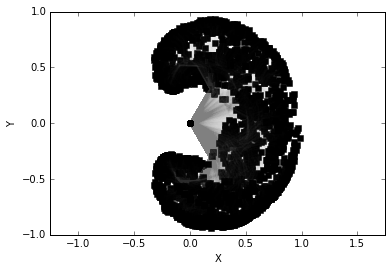

In [6]:
%pylab inline
ax = axes()
plt.axis('equal')

print "# Points in database:", len(model.model.imodel.fmodel.dataset)
for i in range(len(model.model.imodel.fmodel.dataset)):
    m = model.model.imodel.fmodel.dataset.get_x(i)
    environment.plot_arm(ax, m, alpha=0.01)
    

Now we can compare the area explored with Goal Babbling and direct CMAES optimization, versus the area reached only with random motor commands:

Populating the interactive namespace from numpy and matplotlib


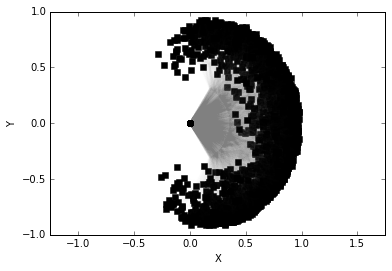

In [7]:
%pylab inline
ax = axes()
plt.axis('equal')

for m in environment.random_motors(n=len(model.model.imodel.fmodel.dataset)):
    environment.plot_arm(ax, m, alpha=0.01)

Random Goal Babbling with direct optimization allowed to explore a larger part of the reachable space than Random Motor Babbling !